In [130]:
from DistantSpeech.beamformer.utils import load_audio
from scipy.signal import convolve as conv
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from DistantSpeech.adaptivefilter import BaseFilter, awgn, FastFreqLms, Mdf
from DistantSpeech.adaptivefilter.FastFreqLms import FastFreqLms
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.adaptivefilter.get_rir import get_rir
from DistantSpeech.beamformer.utils import pt

(336567,)
<class 'numpy.float32'>
[-1.2207404e-04 -2.4414808e-04 -2.1362957e-04 ... -6.1037019e-05
  0.0000000e+00  0.0000000e+00]


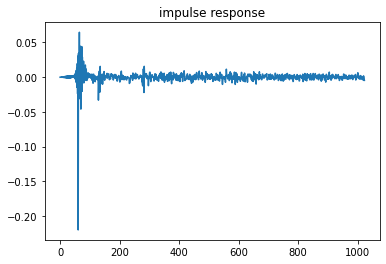

In [131]:
# load source single and rir
src = load_audio('/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav')
src = np.random.rand(len(src))-0.5# * np.sqrt(npower)
print(src.shape)
rir = load_audio('/home/wangwei/work/DistantSpeech/DistantSpeech/adaptivefilter/rir_t60_114.wav')
rir = get_rir()[0][0]
rir = load_audio('/home/wangwei/work/DistantSpeech/DistantSpeech/adaptivefilter/rir.wav')
print(type(rir[0]))
print(rir)
rir = rir[200:]
filter_len = 1024

# same rir as paper
# rir = np.zeros(128)
# for n in range(128):
#     rir[n] = (-1)**n*np.exp(-0.04*(n+1))
# filter_len = 128


rir = rir[:filter_len, np.newaxis]
plt.figure()
plt.plot(rir)
plt.title('impulse response')
plt.show()

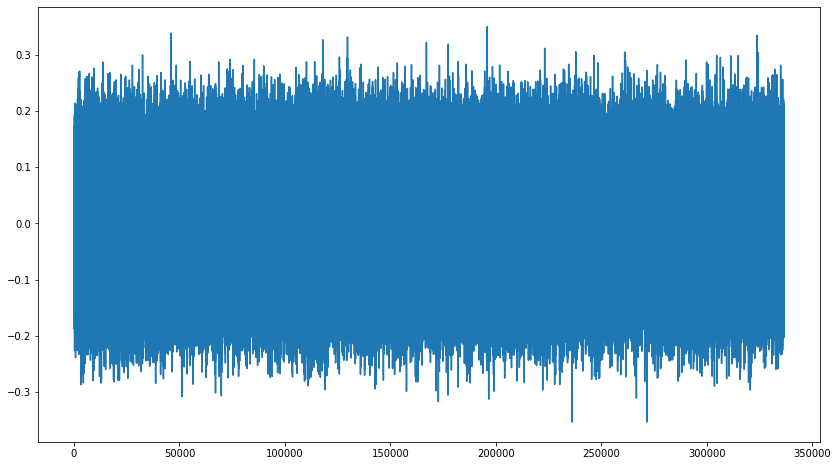

(336567,)
(336567,)


100%|██████████| 335543/335543 [00:11<00:00, 29300.33it/s]


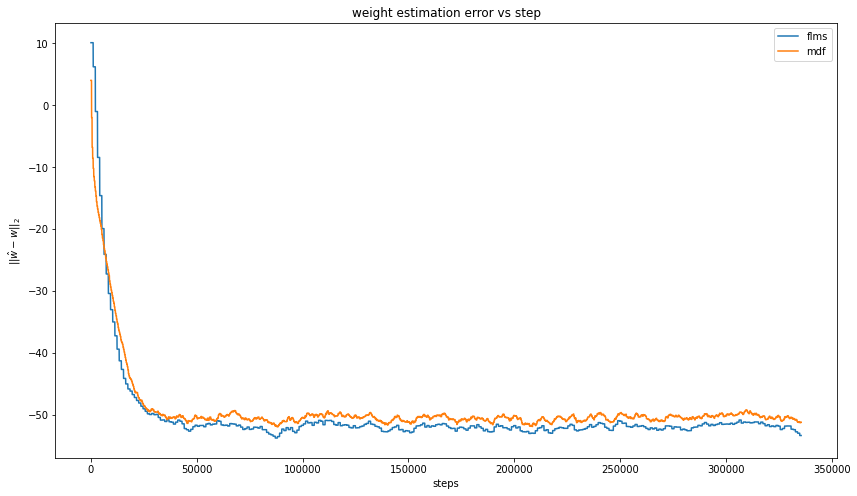

In [132]:


# src = awgn(src, 30)

SNR = 10
data_clean = conv(src, rir[:, 0])
data = data_clean[:len(src)]
data = awgn(data, SNR)

pt(data)

print(src.shape)
print(data.shape)

# array_data = audioread("/home/wangwei/work/DistantSpeech/example/mix.wav")
# src = array_data[:, 0]
# data = array_data[:, 1]

w = np.zeros((filter_len, 1))

lms = BaseFilter(filter_len=filter_len, mu=0.001, normalization=False)
nlms = BaseFilter(filter_len=filter_len, mu=0.1)
flms = FastFreqLms(filter_len=filter_len, mu=1.e-1)
mdf = Mdf(filter_len=filter_len, mu=1.1e-1, num_block=4)

valid_len = len(src)-flms.filter_len  # discard last frame

est_err_lms = np.zeros(valid_len)
est_err_nlms = np.zeros(valid_len)
est_err_flms = np.zeros(valid_len)
est_err_mdf = np.zeros(valid_len)

output = np.zeros(data.shape)

for n in tqdm(range((valid_len))):
    if np.mod(n, flms.filter_len) == 0:
        input_vector = src[n: n +  flms.filter_len]
        d_vector = data[n : n + flms.filter_len]
        err, w_flms = flms.update(input_vector, d_vector)
        output[n : n + flms.filter_len] = err[:, 0]

    if np.mod(n, mdf.block_len) == 0:
        input_vector = src[n: n +  mdf.block_len]
        d_vector = data[n : n + mdf.block_len]
        err, w_mdf = mdf.update(input_vector, d_vector)

    # _, w_lms = lms.update(src[n], data[n])
    # _, w_nlms = nlms.update(src[n], data[n])
    # est_err_lms[n] = np.sum(np.abs(rir - w_lms[:len(rir)])**2)
    # est_err_nlms[n] = np.sum(np.abs(rir - w_nlms[:len(rir)])**2)
    est_err_flms[n] = np.sum(np.abs(rir - w_flms[:len(rir)])**2)
    est_err_mdf[n] = np.sum(np.abs(rir - w_mdf[:len(rir)])**2)

plt.figure(figsize=(14,8))
# plt.plot(10 * np.log(est_err_lms / np.sum(np.abs(rir[:, 0])**2) + 1e-6))
# plt.plot(10 * np.log(est_err_nlms / np.sum(np.abs(rir[:, 0])**2)) + 1e-6)
plt.plot(10 * np.log(est_err_flms / np.sum(np.abs(rir[:, 0])**2)) + 1e-6)
plt.plot(10 * np.log(est_err_mdf / np.sum(np.abs(rir[:, 0])**2)) + 1e-6)
plt.legend(['flms', 'mdf'], loc='upper right')
plt.xlabel("steps")
plt.ylabel("$\||\hat{w}-w\||_2$")
plt.title('weight estimation error vs step')
plt.show()

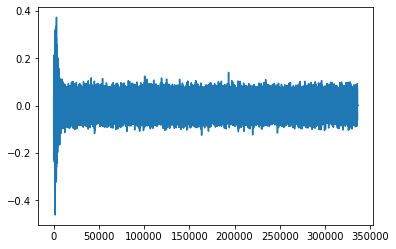

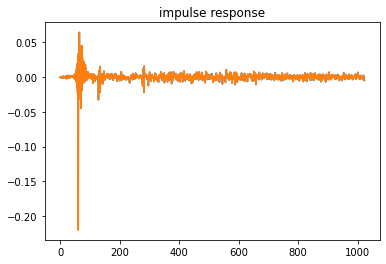

In [133]:
plt.figure()
plt.plot(output)
plt.show()
# audiowrite('flms1.wav', output)
# print(w_mdf)
plt.figure()
plt.plot(w_mdf)
plt.plot(w_flms)
plt.title('impulse response')
plt.show()
# plt.figure()
# plt.plot(w_mdf)
# plt.title('impulse response')
# plt.show()

audiowrite('x.wav', src)
audiowrite('d.wav', data)
audiowrite('rir_x_d.wav', rir)